In [1]:
!pip install --upgrade pip
!pip install python-decouple
!pip install geoalchemy2
!pip install shapely
!pip install scipy
!pip install tpot

Requirement already up-to-date: pip in /anaconda3/lib/python3.7/site-packages (19.1.1)


In [2]:
from sqlalchemy import create_engine, func, text
from sqlalchemy.orm import sessionmaker
from decouple import config
from shapely import wkb, wkt
from shapely.geometry import Point
from geoalchemy2.shape import to_shape 

import pandas as pd
import numpy as np
import random
import json
from datetime import datetime, timedelta
import re
from matplotlib import pyplot as plt

from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from IPython.core.debugger import set_trace

Using TensorFlow backend.


In [3]:
"""Contains models for DB."""

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, BigInteger, Integer, String, DateTime, ForeignKey, Float
from sqlalchemy.orm import relationship
from geoalchemy2 import Geometry


BASE = declarative_base()


class City(BASE):
    """City model for DB. Has information of cities."""
    __tablename__ = 'city'
    id            = Column(BigInteger, primary_key=True)
    city          = Column(String, unique=False, nullable=False)
    state         = Column(String, unique=False, nullable=True)
    country       = Column(String, unique=False, nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    blocks        = relationship("Blocks", back_populates="city")
    zipcodes      = relationship("ZipcodeGeom", back_populates="city")
    incidents     = relationship("Incident", back_populates="city")


class Blocks(BASE):
    """Block model for DB. Has information of city blocks for a related city
        id."""
    __tablename__ = 'block'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    population    = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="blocks")
    incidents     = relationship("Incident", back_populates="block")

class ZipcodeGeom(BASE):
    """Zipcode geometry model for DB. Has information of zipcodes and related
        city id."""
    __tablename__ = 'zipcodegeom'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    zipcode       = Column(String, nullable=False, unique=True)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    city          = relationship("City", back_populates="zipcodes")

class Incident(BASE):
    """Incident model for DB. Has information of a specific crime, including
        where it took place, when it took place, and the type of crime that
        occurred."""
    __tablename__ = 'incident'
    id            = Column(BigInteger, primary_key=True)
    crimetypeid   = Column(BigInteger, ForeignKey('crimetype.id'), nullable=False)
    locdescid     = Column(BigInteger, ForeignKey('locdesctype.id'), nullable=False)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    blockid       = Column(BigInteger, ForeignKey('block.id'), nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    datetime      = Column(DateTime, nullable=False)
    hour          = Column(Integer, nullable=False)
    dow           = Column(Integer, nullable=False)
    month         = Column(Integer, nullable=False)
    year          = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="incidents")
    block         = relationship("Blocks", back_populates="incidents")
    crimetype     = relationship("CrimeType", back_populates="incidents")
    locationdesc  = relationship("LocationDescriptionType", back_populates="incidents")

class CrimeType(BASE):
    """CrimeType model for DB. Has information of the types of crime, including
        a general description and the numerical severity of the crime."""
    __tablename__ = 'crimetype'
    id            = Column(BigInteger, primary_key=True)
    category      = Column(String, unique=True, nullable=False)
    severity      = Column(Integer, nullable=False)
    incidents     = relationship("Incident", back_populates="crimetype")


class LocationDescriptionType(BASE):
    """Location description model for DB. Has information on the type of
        location that the crime took place."""
    __tablename__ = 'locdesctype'
    id            = Column(BigInteger, primary_key=True)
    key1          = Column(String, nullable=False)
    key2          = Column(String, nullable=False)
    key3          = Column(String, nullable=False)
    incidents     = relationship("Incident", back_populates="locationdesc")

In [4]:
class GetData(object):
    def go(self, SESSION, start_year, end_year):
        SQL_QUERY = \
            f'''
                SELECT
                    incident.blockid,
                    incident.year,
                    incident.month,
                    incident.dow,
                    incident.hour,
                    SUM(crimetype.severity)/AVG(block.population) AS severity
                FROM incident
                INNER JOIN block ON incident.blockid = block.id
                INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                    AND block.population > 0
                    AND incident.cityid = 1
                    AND incident.year >= {start_year}
                    AND incident.year <= {end_year}
                GROUP BY
                    incident.blockid,
                    incident.year,
                    incident.month,
                    incident.dow,
                    incident.hour
            '''
        return SESSION.execute(text(SQL_QUERY)).fetchall()

In [45]:
def process_data(data, start_year, end_year, map_risk):

    # records is the list of rows we get from the query with this order:
    #   blockid, year, month, dow, hour, risk
    #   month is from 1 - 12
    #   `POINT(<lat> <lng>)`
    
    NUM_BLOCKIDS = 801
    START_MONTH = START_MONTH_LAST_YEAR = 1
    
    if (end_year - start_year + 1) != 3:
        raise ValueError('3 years must be passed in')

    years_data_X = years_data_y = 2
    X = np.zeros((NUM_BLOCKIDS, years_data_X*12*7*24 + 1))
    y = np.zeros((NUM_BLOCKIDS, years_data_y*12*7*24 + 1))

    for r in data:
        if r[1] == start_year:
            X[r[0]-1, (((12*r[1]+r[2]-1)-(start_year*12+START_MONTH-1))*7+r[3])*24+r[4]] = float(r[5])
        elif r[1] == end_year:
            y[r[0]-1, (((12*r[1]+r[2]-1)-(end_year*12+START_MONTH_LAST_YEAR-1))*7+r[3])*24+r[4]] = float(r[5])
        else:  # common years to X and y
            if r[1] == start_year+1:
                X[r[0]-1, (((12*r[1]+r[2]-1)-(start_year*12+START_MONTH-1))*7+r[3])*24+r[4]] = float(r[5])
            else:
                y[r[0]-1, (((12*r[1]+r[2]-1)-(end_year*12+START_MONTH_LAST_YEAR-1))*7+r[3])*24+r[4]] = float(r[5])
            
        #         if r[1] == end_year:
        #             y[r[0]-1, (((12*r[1]+r[2]-1)-(end_year*12+START_MONTH_LAST_YEAR-1))*7+r[3])*24+r[4]] = float(r[5])
        #         else:
        #             X[r[0]-1, (((12*r[1]+r[2]-1)-(start_year*12+START_MONTH-1))*7+r[3])*24+r[4]] = float(r[5])

    NUM_DATA_POINTS_TO_USE = len(X) * ((NUM_BLOCKIDS-1) + (end_year - start_year + 1)*12*7*24 + 1)//2
    
    X[:, -1] = start_year*12+START_MONTH-1

    return [x1 for xs in X for x1 in xs], [y1 for ys in y for y1 in ys]



In [46]:
from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""

    DB_URI  = config('DB_URI')
    ENGINE  = create_engine(DB_URI)
    Session = sessionmaker(bind=ENGINE)
    SESSION = Session()
    
    try:
        yield SESSION
        SESSION.commit()
    except:
        SESSION.rollback()
        raise
    finally:
        SESSION.close()


def ready_data(training_start_year, training_end_year,
               testing_start_year, testing_end_year,
               map_risk):
    with session_scope() as session:
        training_data = GetData().go(session,
                                     training_start_year,
                                     training_end_year)
        testing_data = GetData().go(session,
                                     testing_start_year,
                                     testing_end_year)
        
        X_train, y_train = process_data(training_data,
                                        training_start_year, 
                                        training_end_year,
                                        map_risk)
        X_test, y_test = process_data(testing_data,
                                      testing_start_year, 
                                      testing_end_year,
                                      map_risk)

    return X_train, X_test, y_train, y_test

In [47]:
def map_risk_1(risk):
    return np.power(risk * 1e5, 2)

def map_risk_0(risk):
    return risk

def map_risk_2(risk):
    return np.power(risk * 1e5, 3)

def map_risk_3(risk):
    return np.power(risk * 1e5, 4)

map_risk = [map_risk_1, map_risk_2, map_risk_3]  # , map_risk_1, map_risk_2, map_risk_3]

In [49]:
%%time
X_train, X_test, y_train, y_test = ready_data(2015, 2017, 2016, 2018, map_risk_0)
print(len(X_train), len(y_train), len(X_test), len(y_test))

3230433 3230433 3230433 3230433
CPU times: user 4.76 s, sys: 689 ms, total: 5.44 s
Wall time: 50.3 s


In [52]:
X_train_saved, y_train_saved, X_test_saved, y_test_saved = X_train, y_train, X_test, y_test

In [54]:
X_train = pd.DataFrame(data=X_train, columns=['risk_past'])
y_train = pd.DataFrame(data=y_train, columns=['risk_future'])
X_test = pd.DataFrame(data=X_test, columns=['risk_past'])
X_test = pd.DataFrame(data=X_test, columns=['risk_future'])

In [ ]:
# X_train = pd.DataFrame(data={'idx': range(len(X_train)),
#                              'risk_past': X_train})
# y_train = pd.DataFrame(data={'idx': range(len(y_train)),
#                              'risk_future': y_train})
# X_test = pd.DataFrame(data={'idx': range(len(X_test)),
#                              'risk_past': X_test})
# y_test = pd.DataFrame(data={'idx': range(len(y_test)),
#                              'risk_future': y_test})

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'n_estimators':  [80, 100, 120, 1000],
    'max_depth': [2, 3, 4, 5],
}

gridsearch = GridSearchCV(XGBRegressor(),
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=3, n_jobs=-1,
                          return_train_score=True, verbose=10)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.7min


In [79]:
print('  Best training score from grid search:', -gridsearch.score(X_train, y_train))
print('  Best testing score from grid search: ', -gridsearch.score(X_test, y_test))
print('Best Grid Search model:')
gridsearch.cv_results_['params'][gridsearch.best_index_]

  Best training score from grid search: 0.5913586709790265
  Best testing score from grid search:  0.5825633204510984
Best Grid Search model:


{'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 120}

In [80]:
y_pred = gridsearch.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))

MSE: 0.5825633204510984


In [81]:
def plot_output(y, y_pred, dataset_type):

    fig = plt.figure(figsize=(10, 8))
    plt.scatter(np.arange(len(y.flatten())),
                 y.flatten(), color='blue');
    plt.scatter(np.arange(len(y_pred.flatten())),
                 y_pred.flatten(), color='red',
                s=1);
    plt.xlabel('Sample number', fontsize=16)
    plt.ylabel('Risk', fontsize=18)
    plt.title(dataset_type + ' dataset', fontsize=18)
    plt.legend(labels=['risk', 'predicted risk'], prop={'size': 20})
    plt.show()

In [82]:
len(y_pred)

262969

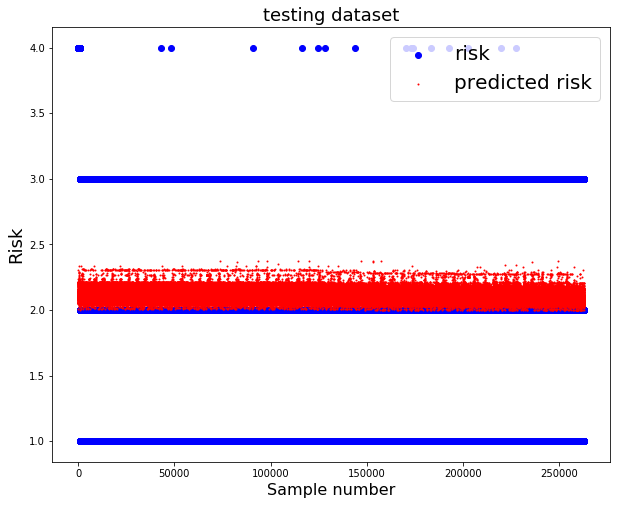

In [83]:
plot_output(y_test.values, y_pred, 'testing')

In [84]:
y_test.value_counts()

2    106476
3     95413
1     60282
4       798
Name: risk, dtype: int64

## TPOT

In [85]:
from tpot import TPOTRegressor

In [86]:
%%time

# tpot = TPOTRegressor(generations=10, population_size=10, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LassoLarsCV(input_matrix, normalize=False)
-0.5845247485551336
CPU times: user 3min 51s, sys: 7.04 s, total: 3min 58s
Wall time: 3min 49s


In [87]:
y_val_predict = tpot.predict(X_val)
mean_squared_error(y_val, y_val_predict)

NameError: name 'X_val' is not defined